In [8]:
import re
import os
import json
import pickle
import config
import spotipy
import numpy as np
import pandas as pd
import time
import random
import seaborn as sns

from datetime import date
from spotipy.oauth2 import SpotifyOAuth
from scipy.spatial.distance import cdist

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# import boto3



In [2]:
# Credentials
os.environ["SPOTIPY_CLIENT_ID"] = config.SPOTIPY_CLIENT_ID
os.environ["SPOTIPY_CLIENT_SECRET"] = config.SPOTIPY_CLIENT_SECRET
os.environ['SPOTIPY_REDIRECT_URI'] = config.SPOTIPY_REDIRECT_URI  # Needed for user authorization

# Defining scope to read user playlist and write playlist to user
scope = 'user-library-read user-follow-read playlist-modify-private playlist-modify user-top-read'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [31]:
# Pickled models
# Base 2%
model_path = 'models/KMeans_K17_20000_sample_model.sav'
tsne_path = 'models/openTSNETransformer.sav'
scaler_path = 'models/StdScaler.sav'
playlists_path = 'data/playlists.json'
train_data_scaled_path = 'data/scaled_data.csv'
df_opentsne_path = 'data/df_openTSNE_20000.csv'
df_path = 'data/Playlist_Feats.csv'

# 100,000 samples
# model_path = 'models/KMeans_K17_100000_sample_model.sav'
# tsne_path = 'models/openTSNETransformer_100000.sav'
# scaler_path = 'models/StdScaler_100000.sav'
# playlists_path = 'data/playlists_100000.json'
# train_data_scaled_path = 'data/scaled_data_100000.csv'
# df_opentsne_path = 'data/df_openTSNE_100000.csv'


In [90]:
class SpotifyRecommendations():
    """
    This Class will provide music recommendations in a form of Playlists
    Attributes:
        - model_path (str): Path to where the model is saved, should be pretrained.
        - tsne_path (str): Path to where the TSNE transformer is saved, should be pretrained.
        - scaler_path (str): Path to where the Standar Scaler transformer is saved, should be pretrained.
        - playlists_path (str): Path to where the Playlists file is saved, will represent the pool provide recommendations.
        - scaled_data_path (str): Path to where the Scaled Data is saved, all playlists used for training should be present.
    
        This function will compute the most similar or disimilar playlists given a target vector 'y' which represents the mean
        features of the user's favorite songs. Similarity is calculated based on metrics such as Cosine, Manhattan, Euclidean, etc.
        Parameters:
            - model: Trained clustering model.
            - train_data_scaled_feats_df (dataframe): Dataframe with scaled data for all the training data
            - playlists (dictionary): Dictionary with all the playlists from the .json files
            - y (np.array): user's favorite songs scaled vector
            - n (int): top n playlists to retrieve
            - metric (str): metric to use, recommended 'cityblock', 'euclidean', 'cosine'.
            - similar (bool): whether to calculate most similar or most disimilar 
            - printing (bool): whether to print the results or not
        Output:
            - indices (np.array): indices of the top n playlists based on the train_data_scaled_feats_df dataframe

    """
    def __init__(self, model_path, tsne_path, scaler_path, playlists_path, train_data_scaled_path, df_opentsne_path, df_path):
        """
        Inits class with hard coded values for the Spotify instance and gets the paths for all the models and data
        """
        # Hardcoded init variables
        self.scope = 'user-library-read user-follow-read playlist-modify-private playlist-modify' # Defining scope to read user playlist and write playlist to user
        self.sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))
        self.feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                               'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

        # Model loading
        self.model = pickle.load(open(model_path, 'rb'))
        self.tsne_transformer = pickle.load(open(tsne_path, 'rb'))
        self.scaler = pickle.load(open(scaler_path, 'rb'))

        # Data loading
        self.playlists = json.load(open(playlists_path, "r"))
        # bucket = "capstone-mads-spotify"
        # file_name = '2021_30_30_14_01_32_playlists_1000000.json'
        # s3 = boto3.client('s3') 
        # obj = s3.get_object(Bucket= bucket, Key= file_name) 
        # self.playlists = json.load(obj['Body']) # 'Body' is a key word

        self.train_scaled_data = np.loadtxt(train_data_scaled_path, delimiter=',')
        self.train_data_scaled_feats_df = pd.DataFrame(self.train_scaled_data)
        self.df_opentsne = pd.read_csv(df_opentsne_path)
        self.df = pd.read_csv(df_path)
        print('Class Initialized')

        for attempt in range(10):
            try:
                us = sp.current_user()
                print('Spotify connection initialized for {}'.format(us['display_name']))
            except Exception as e: 
                print(e)
                print('Reconnecting...')
            else:
                break
        else:
            print('Spotify Connection Failed')

    def get_current_user_fav_tracks(self):
        "Get all favorite tracks from current user and return them in a dataframe"

        tracks = self.sp.current_user_saved_tracks()

        song = []
        artist = []
        uri = []
        self.artist_uri = []

        #First pass of the user's saved tracks
        for i in tracks['items']:
            song.append(i['track']['name'])
            artist.append(i['track']['artists'][0]['name'])
            uri_id = i['track']['uri']
            uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])
            self.artist_uri.append(i['track']['artists'][0]['id'])

        # Keep looking in tracks for the rest of the user's saved tracks, they are paginated
        while tracks['next']:
            tracks = sp.next(tracks)
            for i in tracks['items']:
                song.append(i['track']['name'])
                artist.append(i['track']['artists'][0]['name'])
                uri_id = i['track']['uri']
                uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])
                self.artist_uri.append(i['track']['artists'][0]['id'])

        # Create a dataframe from info extracted above, song, artist and uri
        self.fav_songs_df = pd.DataFrame(
            {'song': song,
            'artist': artist,
            'uri': uri,
            'artist_uri':self.artist_uri
            })
        return self.fav_songs_df

    def get_current_user_audio_features(self):
        "Extract audio features from each track from the user's favorite tracks and return a dataframe"
        try:
            self.fav_songs_df # Checks if it exist else runs the function to get the variable
        except:
            self.get_current_user_fav_tracks()
        
        appended_df = []
        for i in self.fav_songs_df['uri']:
            appended_df.append(pd.DataFrame(sp.audio_features(i)[0], index=[i,]))
        uri_df = pd.concat(appended_df)
        uri_df = uri_df.drop(['uri'], axis=1)
        uri_df = uri_df.reset_index()
        uri_df = uri_df.rename(columns={"index": "uri"})

        self.fav_songs_feats_df = pd.merge(self.fav_songs_df, uri_df, on="uri")
        return self.fav_songs_feats_df

    def get_user_raw_y(self):
        "Get user 'y' vector without scaling"
        try:
            self.fav_songs_feats_df # Checks if it exist else runs the function to get the variable
        except:
            self.get_current_user_audio_features()

        self.raw_y = self.fav_songs_feats_df[self.feat_cols_user].mean()
        return self.raw_y

    def get_user_scaled_y_vector(self):
        "Get user 'y' vector after scaling in a numpy array with shape of (1,n)"
        try:
            self.raw_y # Checks if it exist else runs the function to get the variable
        except:
            self.get_user_raw_y()
            
        self.scaled_y = self.scaler.transform(np.array(self.raw_y).reshape(1,-1))
        return self.scaled_y

    def get_top_n_playlists(self, n=10, metric='cityblock', similar=True, printing=False):
        """
        This function will compute the most similar or disimilar playlists given a target vector 'y' which represents the mean
        features of the user's favorite songs. Similarity is calculated based on metrics such as Cosine, Manhattan, Euclidean, etc.
        Parameters:
            - model: Trained clustering model.
            - train_data_scaled_feats_df (dataframe): Dataframe with scaled data for all the training data
            - playlists (dictionary): Dictionary with all the playlists from the .json files
            - scaled_y (np.array): user's favorite songs scaled vector
            - n (int): top n playlists to retrieve
            - metric (str): metric to use, recommended 'cityblock', 'euclidean', 'cosine'.
            - similar (bool): whether to calculate most similar or most disimilar 
            - printing (bool): whether to print the results or not
        Output:
            - top_playlists (np.array): indices of the top n playlists based on the train_data_scaled_feats_df dataframe
        
        """
        try:
            self.scaled_y
        except:
            self.get_user_scaled_y_vector()


        # Get labels from model and predict user cluster
        self.train_data_scaled_feats_df['cluster'] = pd.Categorical(self.model.labels_)
        self.user_cluster = self.model.predict(self.scaled_y)
        
        # Slice df for the predicted cluster and get Playlist IDs (PIDs)
        df_slice = self.train_data_scaled_feats_df[self.train_data_scaled_feats_df['cluster']==self.user_cluster[0]]
        df_slice = df_slice.drop(['cluster'], axis=1)
        indices = self.train_data_scaled_feats_df[self.train_data_scaled_feats_df['cluster']==self.user_cluster[0]].reset_index()['index'].to_numpy() # PIDs for the cluster
        
        # Convert df slice to numpy, compute similarities and grab the top n PIDs
        sliced_data_array = df_slice.to_numpy()
        if similar:
            simi = cdist(sliced_data_array, self.scaled_y, metric=metric).argsort(axis=None)[:n]
        else:
            simi = cdist(sliced_data_array, self.scaled_y, metric=metric).argsort(axis=None)[-n:]
        self.top_playlists = indices[simi]
        
        if printing:
            for idx in simi:
                print('Playlist: {}\tpid:{}'.format(self.playlists[idx]['name'], self.playlists[idx]['pid']))
                for song in self.playlists[idx]['tracks'][0:3]:
                    print('Artist: {}\t Song:{}'.format(song['artist_name'], song['track_name']))
                print('\n')
        
        return self.top_playlists

    def get_songs_recommendations(self, n=30, printing=False):
        """
        This function computes the variance, of each song in the given playlists, to the user's favorite songs (scaled_y)
        Parameters:
            - n (int): number of songs to recommend, default to 30.
            - printing (bool): Flag to print or not the song recommendations, default to False.
        """

        try:
            self.top_playlists
        except:
            self.get_top_n_playlists()

        # Old code
        # playlist_audio_features = []
        # for playlist in self.top_playlists:
        #     for song in self.playlists[playlist]['tracks']:
        #         playlist_audio_features.append(sp.audio_features(song['track_uri'].split("k:")[1])[0])
        # end of old code

        ### New Code
        playlist_audio_features = []
        audio_feats = []
        for playlist in self.top_playlists:
            all_uris_in_plylst = []
            for track in self.playlists[playlist]['tracks']:
                uri = track['track_uri'].split("k:")[1]
                all_uris_in_plylst.append(uri)
                
            chunks_uris = [all_uris_in_plylst[i:i + 100] for i in range(0, len(all_uris_in_plylst), 100)]
            for chunk in  chunks_uris:
                for attempt in range(100):
                    try:
                        chunk_audio_feats = sp.audio_features(chunk)
                        audio_feats.append(chunk_audio_feats)
                    except Exception as e: 
                        print(e)
                        print('playlist: {}, chunk: {}'.format(playlist['name'], chunk))
                    else:
                        break
                else:
                    print('Everything failed')
        playlist_audio_features = [item for sublist in audio_feats for item in sublist]    
        # End of new code



        playlist_audio_features_df = pd.DataFrame(playlist_audio_features)
        array_audio_feats = playlist_audio_features_df[self.feat_cols_user].to_numpy()
        
        y_vector = np.array(self.raw_y).reshape(1,-1)
        low_variance_indices = np.sum(np.square((y_vector-array_audio_feats)),axis=1).argsort(axis=None)
        self.song_uris = playlist_audio_features_df.loc[low_variance_indices]['id']
        self.song_uris.drop_duplicates(inplace=True)
        self.song_uris = self.song_uris[:n]

        if printing:
            for uri in self.song_uris:
                print('Song: {}'.format(sp.track(uri)['name']))
                print('Artist: {}\n'.format(sp.track(uri)['artists'][0]['name']))

        return self.song_uris

    def build_spotify_playlist(self, playlist_name='Machine Learning Playlist', 
                               description='Hell yeah, this is a Machine Learning Playlist generated on {}'.format(date.today().strftime("%B %d, %Y")), 
                               playlist = False, n=10):
        """
        Build and Publish Spotify Playlist
        Parameters:
            - playlist_name (str): Name of playlist.
            - decription (str): Description of playlist.
            - target (str): 'user' or 'playlist', user will use user's favorite tracks and playlist will 
        """
        if playlist == False:
            try:
                self.song_uris
            except:
                self.get_songs_recommendations()

            items = self.song_uris.to_list()
            user_id = sp.current_user()['id']
            new_playlist = sp.user_playlist_create(user_id, playlist_name, description=description)
            sp.playlist_add_items(new_playlist['id'],items=items)
        else:
            self.get_playlist_tracks(playlist)
            self.get_playlist_audio_features()
            self.get_playlist_raw_y()
            self.get_playlist_scaled_y_vector()
            self.get_playlist_top_n_playlists(n=n)
            self.get_playlist_songs_recommendations()

            items = self.plylst_song_uris.to_list()
            user_id = sp.current_user()['id']
            new_playlist = sp.user_playlist_create(user_id, playlist_name, description=description)
            sp.playlist_add_items(new_playlist['id'],items=items)
            
    def get_playlist_tracks(self, playlist):
        plylst = sp.playlist(playlist)
        song = []
        artist = []
        uri = []
        for i in plylst['tracks']['items']:
            song.append(i['track']['name'])
            artist.append(i['track']['artists'][0]['name'])
            uri_id = i['track']['uri']
            uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

        self.plylst_songs_df = pd.DataFrame(
            {'song': song,
            'artist': artist,
            'uri': uri
            })
        return self.plylst_songs_df

    def get_playlist_audio_features(self):
        "Extract audio features from each track from the target playlist tracks and return a dataframe"
        try:
            self.plylst_songs_df # Checks if it exist else runs the function to get the variable
        except:
            self.get_playlist_tracks()
        
        appended_df = []
        for i in self.plylst_songs_df['uri']:
            appended_df.append(pd.DataFrame(sp.audio_features(i)[0], index=[i,]))
        uri_df = pd.concat(appended_df)
        uri_df = uri_df.drop(['uri'], axis=1)
        uri_df = uri_df.reset_index()
        uri_df = uri_df.rename(columns={"index": "uri"})

        self.plylst_feats_df = pd.merge(self.plylst_songs_df, uri_df, on="uri")
        return self.plylst_feats_df

    def get_playlist_raw_y(self):
        "Get user 'y' vector without scaling"
        try:
            self.plylst_feats_df # Checks if it exist else runs the function to get the variable
        except:
            self.get_playlist_audio_features()

        self.plylst_raw_y = self.plylst_feats_df[self.feat_cols_user].mean()
        return self.plylst_raw_y

    def get_playlist_scaled_y_vector(self):
        "Get user 'y' vector after scaling in a numpy array with shape of (1,n)"
        try:
            self.plylst_raw_y # Checks if it exist else runs the function to get the variable
        except:
            self.get_playlist_raw_y()
            
        self.plylst_scaled_y = self.scaler.transform(np.array(self.plylst_raw_y).reshape(1,-1))
        return self.plylst_scaled_y

    def get_playlist_top_n_playlists(self, n=10, metric='cityblock', similar=True, printing=False):
        """
        This function will compute the most similar or disimilar playlists given a target vector 'y' which represents the mean
        features of the user's favorite songs. Similarity is calculated based on metrics such as Cosine, Manhattan, Euclidean, etc.
        Parameters:
            - model: Trained clustering model.
            - train_data_scaled_feats_df (dataframe): Dataframe with scaled data for all the training data
            - playlists (dictionary): Dictionary with all the playlists from the .json files
            - plylst_scaled_y (np.array): user's favorite songs scaled vector
            - n (int): top n playlists to retrieve
            - metric (str): metric to use, recommended 'cityblock', 'euclidean', 'cosine'.
            - similar (bool): whether to calculate most similar or most disimilar 
            - printing (bool): whether to print the results or not
        Output:
            - plylst_top_playlists (np.array): indices of the top n playlists based on the train_data_scaled_feats_df dataframe
        
        """
        try:
            self.plylst_scaled_y
        except:
            self.get_playlist_scaled_y_vector()


        # Get labels from model and predict user cluster
        self.train_data_scaled_feats_df['cluster'] = pd.Categorical(self.model.labels_)
        self.plylst_cluster = self.model.predict(self.plylst_scaled_y)
        
        # Slice df for the predicted cluster and get Playlist IDs (PIDs)
        df_slice = self.train_data_scaled_feats_df[self.train_data_scaled_feats_df['cluster']==self.plylst_cluster[0]]
        df_slice = df_slice.drop(['cluster'], axis=1)
        indices = self.train_data_scaled_feats_df[self.train_data_scaled_feats_df['cluster']==self.plylst_cluster[0]].reset_index()['index'].to_numpy() # PIDs for the cluster
        
        # Convert df slice to numpy, compute similarities and grab the top n PIDs
        sliced_data_array = df_slice.to_numpy()
        if similar:
            simi = cdist(sliced_data_array, self.plylst_scaled_y, metric=metric).argsort(axis=None)[:n]
        else:
            simi = cdist(sliced_data_array, self.plylst_scaled_y, metric=metric).argsort(axis=None)[-n:]
        self.plylst_top_playlists = indices[simi]
        
        if printing:
            for idx in simi:
                print('Playlist: {}\tpid:{}'.format(self.playlists[idx]['name'], self.playlists[idx]['pid']))
                for song in self.playlists[idx]['tracks'][0:3]:
                    print('Artist: {}\t Song:{}'.format(song['artist_name'], song['track_name']))
                print('\n')
        
        return self.plylst_top_playlists

    def get_playlist_songs_recommendations(self, n=30, printing=False):
        """
        This function computes the variance, of each song in the given playlists, to the user's favorite songs (plylst_scaled_y)
        Parameters:
            - n (int): number of songs to recommend, default to 30.
            - printing (bool): Flag to print or not the song recommendations, default to False.
        """

        try:
            self.plylst_top_playlists
        except:
            self.get_playlist_top_n_playlists()


        # # Old code working fine but too slow
        # playlist_audio_features = []
        # for playlist in self.plylst_top_playlists:
        #     for song in self.playlists[playlist]['tracks']:
        #         playlist_audio_features.append(sp.audio_features(song['track_uri'].split("k:")[1])[0])
        # # End of old code
        # print(pd.DataFrame(playlist_audio_features))
        # print('\n\n')

        ### New Code
        playlist_audio_features = []
        audio_feats = []
        for playlist in self.plylst_top_playlists:
            all_uris_in_plylst = []
            for track in self.playlists[playlist]['tracks']:
                uri = track['track_uri'].split("k:")[1]
                all_uris_in_plylst.append(uri)
                
            chunks_uris = [all_uris_in_plylst[i:i + 100] for i in range(0, len(all_uris_in_plylst), 100)]
            for chunk in  chunks_uris:
                for attempt in range(100):
                    try:
                        chunk_audio_feats = sp.audio_features(chunk)
                        audio_feats.append(chunk_audio_feats)
                    except Exception as e: 
                        print(e)
                        print('playlist: {}, chunk: {}'.format(playlist['name'], chunk))
                    else:
                        break
                else:
                    print('Everything failed')
        playlist_audio_features = [item for sublist in audio_feats for item in sublist] 
        # End of new code
        # print(pd.DataFrame(playlist_audio_features))

        playlist_audio_features_df = pd.DataFrame(playlist_audio_features)
        array_audio_feats = playlist_audio_features_df[self.feat_cols_user].to_numpy()
        
        y_vector = np.array(self.plylst_raw_y).reshape(1,-1)
        low_variance_indices = np.sum(np.square((y_vector-array_audio_feats)),axis=1).argsort(axis=None)
        self.plylst_song_uris = playlist_audio_features_df.loc[low_variance_indices]['id']
        self.plylst_song_uris.drop_duplicates(inplace=True)
        self.plylst_song_uris = self.plylst_song_uris[:n]

        if printing:
            for uri in self.plylst_song_uris:
                print('Song: {}'.format(sp.track(uri)['name']))
                print('Artist: {}\n'.format(sp.track(uri)['artists'][0]['name']))

        return self.plylst_song_uris

    def get_spotify_wrapped(self):
        "Get Spotify Wrapped for current user"
        try:
            self.artist_uri()
        except:
            self.get_current_user_fav_tracks()

        user = sp.current_user()['display_name']
        followers = sp.current_user()['followers']['total']
        print("Hello {}!".format(user))
        print("We are happy that you are using our product. Let's see some of your personal Spotify stats.\n")
        time.sleep(5)
        if followers >= 1:
            print("At this moment you have a total of {} followers, that's not bad at all!\nThey know you have an amazing music taste.\n".format(followers))
        else:
            print("Ouch, at this moment you don't have any followers, let me know if you want me to follow you. I'll be happy to see what type of music you listen to.\n")
        time.sleep(6)

        top_artists = []
        genres = []
        try:
            for artist in sp.current_user_top_artists(time_range='long_term')['items']:
                top_artists.append(artist['name'])
                genres.append(artist['genres'])
            print("These are your top artist of all time:")
            for i in top_artists[:5]:
                print(i)
            print("\n")
        except:
            print("Ooops, it seems that you don't have top artist at the moment.\n")

        time.sleep(6)
        top_tracks = []
        try:
            print("And these are your top tracks of all time:")
            for i in sp.current_user_top_tracks(time_range='long_term')['items'][:5]:
                print("{} - {}".format(i['name'], i['artists'][0]['name']))
        except:
            print("Ooops, it seems that you don't have top tracks at the moment.\n")


        genres = []
        for artist in self.artist_uri:
            genres.append(sp.artist(artist)['genres'])

        text = [item for sublist in genres for item in sublist]
        text = ' '.join(text)
        text

        sequential =['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 
                    'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

        color = random.choice(sequential)

        wc = WordCloud(background_color ='white',relative_scaling=0, width=500, height=500, colormap=color).generate(text)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title('These are the genres\nyou listen to the most.\n', size=20)
        plt.show()

        # Transform user fav songs to TSNE to plot in vector space
        try:
            self.scaled_y
        except:
            self.get_user_scaled_y_vector()
        try:
            self.user_cluster
        except:
            self.user_cluster = self.model.predict(self.scaled_y)
            
        user_tsne = self.tsne_transformer.transform(self.scaled_y)[0]
        
        self.df_opentsne['cluster'] = pd.Categorical(self.model.labels_)

        # Blob all clusters
        sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=self.df_opentsne, legend=None)
        plt.scatter(x=user_tsne[0], y=user_tsne[1], color='yellow', marker='*', s=500)
        plt.title('There are a total of 17 clusters\nand the Star is where you fall in.')
        plt.show()

        # Blob user cluster
        palette = {c:'purple' if c==self.user_cluster else 'darkgrey' for c in self.df_opentsne.cluster.unique()}
        sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=self.df_opentsne, legend=None, palette=palette)
        plt.scatter(x=user_tsne[0], y=user_tsne[1], color='yellow', marker='*', s=500)
        plt.title('You are in cluster {}'.format(self.user_cluster))
        plt.show()

        # User Cluster
        self.df['cluster'] = pd.Categorical(self.model.labels_)
        df_cat = self.df[self.df['cluster']==self.user_cluster[0]]
        text = ' '.join(df_cat["name"])
        wc = WordCloud(background_color ='white',relative_scaling=0, width=500, height=500, colormap=color).generate(text)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title('Playlist names in your cluster'.format(self.user_cluster), size=20)
        plt.show()


    def __str__(self):
        return 'Spotify Recommender System with model: {} on {} playlists.'.format(self.model, len(self.train_scaled_data))

    


# x = SpotifyRecommendations(model_path, tsne_path, scaler_path, playlists_path, train_data_scaled_path)

In [16]:
# Examples on how to use it
# Need to call SpotifyRecommendations with the given paths for the models and data
x = SpotifyRecommendations(model_path, tsne_path, scaler_path, playlists_path, train_data_scaled_path)

# This will build a playlist based on the current user logged in
x.build_spotify_playlist()

# This will build a playlist based on a playlist
x.build_spotify_playlist(playlist='71vjvXmodX7GgWNV7oOb64')

# Fine tune the recommendations
# n: number of similar playlists
# metric: type of metric, you can try 'euclidean', 'cosine', 'cityblock'
# similar: True for similar False for longest distance but still within the same cluster

x.get_top_n_playlists(n=10, metric='cityblock', similar=True, printing=False) # Fine tune for current user
x.get_playlist_top_n_playlists(n=10, metric='cityblock', similar=True, printing=False) # Fine tune for playlist

# After tuning, run againn build_spotify_playlist() or  build_spotify_playlist()

In [ ]:
# Examples:
x.build_spotify_playlist(playlist='71vjvXmodX7GgWNV7oOb64') # From a previously generated playlist
x.build_spotify_playlist(playlist_name = 'On User') # On current user but giving a playlist name
x.build_spotify_playlist(playlist_name = 'Metal Essentials', playlist='37i9dQZF1DWWOaP4H0w5b0') # Based on a Metal essentials playlist
x.build_spotify_playlist(playlist_name = 'Classical Essentials', playlist='37i9dQZF1DWWEJlAGA9gs0') # Based on a Classical essentials playlist
x.build_spotify_playlist() # On current user with default values


In [91]:
x = SpotifyRecommendations(model_path, tsne_path, scaler_path, playlists_path, train_data_scaled_path, df_opentsne_path, df_path)

Class Initialized
Spotify connection initialized for David Hernandez


Hello David Hernandez!
We are happy that you are using our product. Let's see some of your personal Spotify stats.

At this moment you have a total of 21 followers, that's not bad at all!
They know you have an amazing music taste.

These are your top artist of all time:
Sabino
Gepe
Los Ángeles Azules
Steve Jablonsky
Siddhartha


And these are your top tracks of all time:
Lost - Frank Ocean
Midnight City - M83
Vivir Bailando - Silvestre Dangond
Oh! - Vallis Alps
Vivo Pensando En Ti (feat. Maluma) - Felipe Peláez


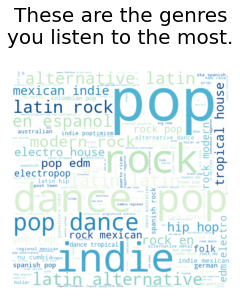

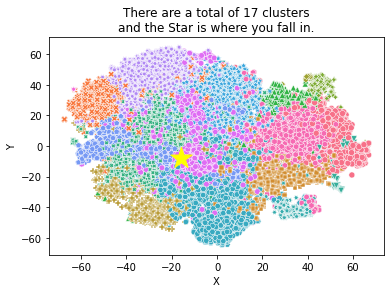

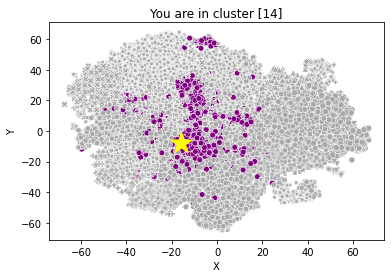

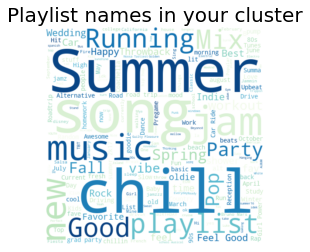

In [53]:
# This will get the spotify wrap on the current user logged in
x.get_spotify_wrapped()

# This will build a playlist based on the current user logged in
# x.build_spotify_playlist()

In [93]:
x.get_top_n_playlists(n=100, metric='cityblock', similar=True, printing=False) # Fine tune for current user
x.get_songs_recommendations()
x.build_spotify_playlist(playlist_name='Machine Learning - Cityblock based on 100 similar playlists')

In [99]:
x.get_top_n_playlists(n=100, metric='cosine', similar=False, printing=False) # Fine tune for current user
x.get_songs_recommendations()
x.build_spotify_playlist(playlist_name='Machine Learning - Cosine based on 100 similar playlists')

In [61]:
x.get_top_n_playlists(n=100, metric='cosine', similar=True, printing=False) # Fine tune for current user
x.get_songs_recommendations()
x.build_spotify_playlist(playlist_name='Machine Learning - Cosine based on 100 similar playlists')

In [94]:
# https://open.spotify.com/playlist/1wOQvu12nUoSdnLpGZ4CRn?si=0bdd04b7f3c24734
x.build_spotify_playlist(n=100, playlist_name = 'Machine Learning Playlist based on Lo-Fi', playlist='1wOQvu12nUoSdnLpGZ4CRn') #Lofi


In [95]:
# https://open.spotify.com/playlist/37i9dQZF1DX4ad1mBZqxYJ?si=d9d583573bb64422
x.build_spotify_playlist(n=100, playlist_name = 'Machine Learning Playlist based on Lo-Fi', playlist='37i9dQZF1DX4ad1mBZqxYJ') #Mex


In [98]:
# https://open.spotify.com/playlist/37i9dQZF1DX905zIRtblN3?si=55ead3babe9e4bb8
x.build_spotify_playlist(n=100, playlist_name = 'Machine Learning Playlist based on Regional Mexicana', playlist='37i9dQZF1DX905zIRtblN3') #RegMex
